In [52]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 

In [53]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import copy

In [54]:
#opening a file to store data
f = open("epid_time_series_ws_pawel.txt","w+") 

In [55]:
#making the nodes interact and hence transfering doses

# @jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,d,p) :
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
        connec_neigh_list = list(G.neighbors(n))
        partner[n,k] = random.choice(connec_neigh_list)
#         print("partner=",partner[n,k])
        z1 = np.random.uniform()

        #if one is infected and the other is susceptible and they are connected
        if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
#         if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        #if both are infected and they are connected
        elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
#         elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
        
    return d

In [56]:
#updating the cumulative dose distribution

def upd_cumu(k,mem_time_steps,d,d_ini) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1)
    
    return D

In [57]:
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform()
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform()
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

    phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     kount = kount + 1

    return phi, indi_state

In [58]:
#creating the static Watts-Strogatz network
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     connec_neigh_list = list(G.neighbors(n))
    
    return G, adj_mat
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

In [59]:
'''infecting connected nodes'''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
#             print('Initial node infection step failed')
            return None
    return infected_nodes

In [60]:
nn = 4
N = 500

G0,ad0 = static_network(N,nn,0)
G1,ad1 = static_network(N,nn,0.1)
G2,ad2 = static_network(N,nn,0.2)
G3,ad3 = static_network(N,nn,0.3)
G4,ad4 = static_network(N,nn,0.4)
G5,ad5 = static_network(N,nn,0.5)
G6,ad6 = static_network(N,nn,0.6)
G7,ad7 = static_network(N,nn,0.7)
G8,ad8 = static_network(N,nn,0.8)
G9,ad9 = static_network(N,nn,0.9)
G10,ad10 = static_network(N,nn,1)

In [61]:
def net_work(val) :
    if val == 0 :
        G = copy.deepcopy(G0)
        adj_mat = copy.deepcopy(ad0)
    elif val == 1 :
        G = copy.deepcopy(G1)
        adj_mat = copy.deepcopy(ad1)
    elif val == 2 :
        G = copy.deepcopy(G2)
        adj_mat = copy.deepcopy(ad2)
    elif val == 3 :
        G = copy.deepcopy(G3)
        adj_mat = copy.deepcopy(ad3)
    elif val == 4 :
        G = copy.deepcopy(G4)
        adj_mat = copy.deepcopy(ad4)
    elif val == 5 :
        G = copy.deepcopy(G5)
        adj_mat = copy.deepcopy(ad5)
    elif val == 6 :
        G = copy.deepcopy(G6)
        adj_mat = copy.deepcopy(ad6)
    elif val == 7 :
        G = copy.deepcopy(G7)
        adj_mat = copy.deepcopy(ad7) 
    elif val == 8 :
        G = copy.deepcopy(G8)
        adj_mat = copy.deepcopy(ad8) 
    elif val == 9 :
        G = copy.deepcopy(G9)
        adj_mat = copy.deepcopy(ad9)
    else :
        G = copy.deepcopy(G10)
        adj_mat = copy.deepcopy(ad10)
        
    return G,adj_mat

In [62]:
#user controlled variables

for p in range(0,11) : #time loop
    p = p*0.1
    for start in range(1,3) : #initial condition loop
        start = start*0.1
        for p_rew in range(0,11) : #probability of rewiring loop
            
            p_rew = p_rew*0.1
            print("p=",p)
            print("start=",start)
            print("p_rew=",p_rew)
            
            nn =  4 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

            rho = 1   #probability of becoming susceptible after recovery
            r = 0.5    #probability of recovery when dose level drops below threshold

            N = 500   #number of individuals
            T = 500  #number of time steps

            mem_time_steps = 2 #the number of previous time steps which the individual remembers about 

#             d_star = 3*np.ones((N,1),dtype=np.int32)
            d_star = 1

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

            partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
            partner = np.asarray(partner)

            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            d_ini = np.zeros((N,mem_time_steps))
            d = 999*np.ones((N,T)) #doses
            D = 999*np.ones((N,T)) #cumulative doses
            
            #creating the static network

            G, adj_mat = net_work(p_rew*10) #calling the function to create the static network
#             print(adj_mat)
#             nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

            #initial state of individuals
            #MEHTODOLOGICALY grouping into i, s or r
            #this is to make a local fraction of the population infected initially
            #previously, random parts/nodes of the population were infected intially 
            
            '''choosing initially infected nodes'''
            infected_nodes = None
            while infected_nodes is None : #infecting 'start' number of network neighbours
                infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start*N)
            print(infected_nodes)
            infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
            indi_state[infected_nodes[:,0],0] = 2
            
            I = np.where(indi_state[:,0]==2)
            I = np.transpose(np.asarray(I))

            if len(I) != 0 :
                for i in range(0,len(I)) : 
                        d_ini[I[i],:] = (d_star+(p*mem_time_steps*10))/mem_time_steps
            else :
                d_ini[:,0:] = 0

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N
            f.write("%f\t" % (phi[0,0]))
            f.flush()
#             print(d_ini)
            for k in range(1,T): #loop for time
#                 print('k = ',k)
                interaction(N,k,adj_mat,indi_state,d,p) #calling the interaction function
#                 print(d)
                upd_cumu(k,mem_time_steps,d,d_ini) #calling the fucntions to obtain and update cumulative dose
#                 print(D)
                upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
#                 print(indi_state)
#             print(phi)
#             phi_star = sum(phi[0,k-5:k])/5 #obtaining average phi_star of the last 100 time steps
#             print("phi_star=",phi_star)

                f.write("%f\t" % (phi[0,k]))
                f.flush()
            f.write("\n")
            f.flush()

p= 0.0
start= 0.1
p_rew= 0.0
{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56}
p= 0.0
start= 0.1
p_rew= 0.1
{393, 155, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 43, 44, 45, 46, 47, 48, 49, 50, 51, 303, 309, 191, 192, 193, 194, 195, 42, 346, 347, 348, 349, 477, 351, 234, 124, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 374, 125}
p= 0.0
start= 0.1
p_rew= 0.2
{262, 394, 142, 143, 145, 407, 408, 409, 410, 411, 412, 285, 413, 414, 161, 49, 50, 51, 52, 436, 53, 54, 309, 438, 434, 326, 327, 328, 329, 330, 331, 332, 333, 334, 201, 336, 335, 202, 203, 205, 204, 86, 349, 198, 487, 488, 489, 490, 199, 200}
p= 0.0
start= 0.1
p_rew= 0.30000000000000004
{128, 257, 2, 384, 389, 138, 10, 398, 400, 402, 147, 277, 283, 155, 27, 161, 293, 171, 176, 307, 439, 58, 318, 448, 192, 453, 454, 326, 327, 73, 332, 79, 469, 345, 347, 351, 357, 231, 3

p= 0.1
start= 0.1
p_rew= 0.0
{169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218}
p= 0.1
start= 0.1
p_rew= 0.1
{391, 392, 394, 395, 396, 411, 412, 413, 414, 314, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 316, 61, 62, 63, 64, 450, 451, 452, 449, 448, 447, 446, 65, 67, 453, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 493, 383}
p= 0.1
start= 0.1
p_rew= 0.2
{0, 1, 2, 3, 4, 5, 137, 265, 139, 141, 13, 15, 150, 152, 410, 411, 412, 413, 414, 31, 33, 34, 35, 36, 37, 179, 195, 323, 325, 324, 326, 328, 73, 74, 75, 72, 472, 473, 474, 475, 362, 363, 364, 365, 366, 495, 496, 497, 498, 499}
p= 0.1
start= 0.1
p_rew= 0.30000000000000004
{4, 135, 392, 268, 397, 15, 143, 146, 19, 148, 149, 20, 407, 408, 411, 157, 160, 290, 292, 298, 176, 49, 179, 438, 56, 442, 322, 197, 327, 72, 202, 75, 464, 

p= 0.2
start= 0.1
p_rew= 0.0
{144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193}
p= 0.2
start= 0.1
p_rew= 0.1
{277, 283, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 445, 200, 201, 202, 199, 203, 204, 473, 474, 475, 476, 477, 478, 479, 349, 481, 480, 492, 493, 494, 495, 496, 497, 498, 116, 117, 118, 119, 121}
p= 0.2
start= 0.1
p_rew= 0.2
{1, 264, 265, 266, 267, 268, 269, 270, 271, 272, 398, 18, 273, 174, 46, 48, 49, 47, 51, 50, 434, 179, 441, 444, 445, 446, 448, 449, 450, 89, 452, 473, 90, 347, 348, 93, 349, 350, 352, 91, 92, 95, 94, 354, 353, 97, 96, 355, 356, 375}
p= 0.2
start= 0.1
p_rew= 0.30000000000000004
{128, 129, 387, 388, 133, 136, 138, 394, 14, 399, 17, 277, 153, 155, 162, 291, 167, 297, 426, 42, 172, 41, 47, 175, 52, 57, 60, 447, 

p= 0.30000000000000004
start= 0.1
p_rew= 0.0
{23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72}
p= 0.30000000000000004
start= 0.1
p_rew= 0.1
{129, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 16, 402, 403, 404, 174, 48, 308, 310, 312, 191, 192, 193, 194, 195, 459, 338, 345, 346, 347, 348, 477, 349, 350, 351, 353, 352, 355, 354, 357, 356, 113, 114, 115, 116, 117, 118, 119, 121}
p= 0.30000000000000004
start= 0.1
p_rew= 0.2
{391, 392, 397, 308, 270, 398, 146, 147, 148, 149, 150, 151, 279, 153, 413, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 445, 192, 193, 194, 195, 196, 69, 198, 197, 217, 218, 473, 219, 223, 97, 354, 229, 230, 109, 372, 373, 374, 375}
p= 0.30000000000000004
start= 0.1
p_rew= 0.30000000000000004
{384, 3, 261, 389, 11, 398, 14, 274, 22, 27, 28, 158, 33, 44, 172, 302, 430, 303, 307, 309, 310, 312, 443

p= 0.30000000000000004
start= 0.2
p_rew= 1.0
{11, 14, 21, 22, 37, 39, 44, 47, 52, 57, 58, 60, 65, 67, 68, 71, 77, 87, 95, 107, 117, 121, 122, 124, 127, 133, 150, 153, 156, 164, 169, 170, 180, 185, 187, 199, 200, 201, 204, 210, 212, 213, 218, 220, 229, 237, 244, 256, 259, 260, 261, 271, 272, 274, 279, 280, 286, 291, 297, 302, 307, 308, 309, 310, 311, 312, 318, 319, 323, 327, 330, 344, 351, 353, 357, 362, 363, 364, 371, 377, 378, 391, 398, 405, 410, 413, 419, 420, 424, 435, 437, 443, 448, 450, 459, 471, 477, 480, 493, 497}
p= 0.4
start= 0.1
p_rew= 0.0
{128, 129, 130, 131, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
p= 0.4
start= 0.1
p_rew= 0.1
{297, 299, 300, 301, 442, 443, 444, 445, 446, 447, 449, 194, 195, 196, 197, 198, 199, 200, 460, 461, 462, 463, 464, 465, 334, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 

p= 0.4
start= 0.2
p_rew= 0.9
{4, 9, 17, 30, 38, 40, 41, 48, 49, 50, 58, 59, 77, 81, 86, 87, 89, 92, 98, 107, 119, 129, 130, 131, 136, 139, 143, 144, 145, 148, 151, 157, 166, 171, 176, 177, 191, 193, 196, 197, 203, 208, 209, 221, 224, 233, 239, 248, 251, 254, 256, 271, 282, 284, 287, 290, 292, 295, 310, 312, 315, 316, 327, 331, 339, 340, 349, 351, 352, 356, 359, 365, 366, 370, 371, 378, 380, 381, 382, 383, 397, 407, 421, 431, 437, 438, 440, 446, 447, 448, 449, 452, 454, 471, 472, 477, 486, 488, 495, 497}
p= 0.4
start= 0.2
p_rew= 1.0
{11, 14, 21, 25, 38, 39, 47, 48, 54, 58, 60, 61, 66, 71, 80, 83, 84, 87, 92, 95, 96, 102, 107, 121, 122, 128, 129, 131, 135, 141, 153, 162, 163, 164, 165, 167, 169, 177, 178, 180, 181, 182, 188, 200, 201, 204, 212, 218, 219, 220, 222, 244, 248, 256, 272, 280, 297, 305, 315, 318, 319, 320, 330, 334, 340, 343, 348, 362, 363, 372, 378, 379, 388, 390, 392, 397, 398, 404, 410, 413, 414, 420, 424, 425, 426, 428, 450, 451, 455, 457, 459, 460, 471, 473, 474, 476, 47

p= 0.5
start= 0.2
p_rew= 0.9
{3, 6, 7, 10, 15, 16, 23, 31, 60, 65, 75, 82, 85, 102, 115, 118, 132, 133, 135, 136, 140, 141, 142, 145, 146, 153, 155, 173, 175, 184, 186, 190, 192, 197, 198, 199, 200, 203, 209, 212, 222, 226, 229, 236, 245, 247, 261, 273, 284, 285, 286, 294, 295, 296, 297, 301, 312, 314, 316, 317, 327, 340, 342, 346, 354, 362, 363, 364, 366, 367, 369, 370, 371, 372, 374, 375, 379, 381, 384, 386, 391, 399, 408, 412, 413, 417, 429, 431, 441, 452, 453, 456, 457, 468, 469, 477, 478, 480, 485, 494}
p= 0.5
start= 0.2
p_rew= 1.0
{7, 11, 12, 20, 22, 24, 26, 33, 37, 44, 60, 64, 65, 69, 76, 80, 83, 84, 107, 116, 118, 122, 126, 129, 134, 137, 140, 149, 153, 155, 159, 180, 187, 193, 198, 200, 210, 214, 216, 220, 223, 227, 230, 234, 235, 239, 242, 245, 247, 248, 256, 259, 261, 263, 266, 267, 274, 277, 282, 285, 286, 287, 289, 291, 292, 293, 302, 304, 307, 310, 311, 312, 314, 316, 320, 327, 332, 335, 343, 345, 353, 363, 375, 377, 389, 392, 403, 409, 419, 422, 423, 424, 425, 439, 461, 

p= 0.6000000000000001
start= 0.2
p_rew= 0.8
{0, 2, 4, 7, 27, 30, 31, 36, 46, 49, 54, 76, 77, 80, 97, 104, 106, 108, 120, 121, 126, 127, 128, 129, 130, 133, 137, 156, 161, 165, 166, 168, 170, 172, 176, 181, 183, 195, 201, 207, 234, 237, 241, 266, 269, 274, 276, 278, 281, 282, 283, 284, 286, 291, 292, 295, 299, 300, 301, 309, 312, 315, 322, 327, 328, 341, 345, 346, 352, 353, 362, 369, 370, 374, 388, 390, 395, 396, 410, 412, 417, 419, 425, 427, 430, 450, 452, 455, 458, 459, 463, 468, 472, 475, 479, 494, 495, 496, 497, 498}
p= 0.6000000000000001
start= 0.2
p_rew= 0.9
{0, 3, 6, 8, 11, 16, 23, 31, 34, 37, 46, 47, 52, 53, 54, 56, 59, 64, 68, 74, 75, 77, 85, 88, 98, 99, 106, 112, 126, 128, 129, 130, 133, 148, 155, 165, 171, 173, 181, 185, 187, 197, 200, 217, 226, 227, 228, 230, 237, 239, 241, 243, 245, 248, 250, 258, 260, 263, 269, 272, 275, 299, 303, 308, 309, 311, 314, 318, 324, 326, 327, 337, 338, 339, 347, 348, 354, 358, 367, 386, 388, 391, 394, 408, 410, 417, 421, 425, 435, 439, 444, 454,

p= 0.7000000000000001
start= 0.2
p_rew= 0.7000000000000001
{1, 5, 7, 11, 12, 14, 22, 25, 30, 36, 37, 39, 41, 44, 54, 65, 75, 78, 79, 83, 86, 87, 88, 91, 103, 108, 113, 115, 124, 127, 130, 147, 148, 157, 166, 170, 185, 188, 200, 205, 210, 215, 231, 232, 236, 242, 244, 247, 253, 259, 261, 263, 274, 279, 283, 285, 286, 288, 298, 302, 307, 310, 311, 312, 316, 323, 330, 333, 342, 347, 352, 355, 356, 360, 363, 364, 367, 377, 382, 388, 395, 398, 413, 414, 416, 418, 420, 422, 425, 431, 436, 439, 445, 452, 454, 459, 466, 471, 477, 478}
p= 0.7000000000000001
start= 0.2
p_rew= 0.8
{1, 4, 17, 22, 25, 33, 35, 36, 51, 54, 74, 77, 83, 84, 86, 106, 108, 111, 114, 140, 141, 142, 144, 145, 159, 160, 165, 166, 171, 174, 184, 191, 196, 203, 204, 205, 206, 207, 210, 220, 226, 235, 248, 250, 251, 252, 253, 254, 257, 263, 265, 266, 268, 269, 273, 299, 307, 309, 310, 315, 317, 318, 320, 322, 323, 325, 336, 341, 343, 357, 370, 376, 378, 380, 382, 385, 387, 395, 401, 414, 422, 424, 425, 433, 434, 435, 437, 439,

p= 0.8
start= 0.2
p_rew= 0.6000000000000001
{9, 12, 14, 15, 17, 18, 19, 20, 25, 29, 33, 36, 42, 47, 53, 57, 60, 66, 67, 68, 71, 80, 86, 102, 107, 115, 116, 118, 122, 129, 137, 147, 148, 149, 158, 159, 163, 165, 175, 177, 178, 194, 196, 199, 200, 208, 209, 217, 220, 221, 228, 229, 234, 243, 245, 248, 255, 256, 267, 273, 278, 282, 287, 304, 305, 306, 314, 316, 317, 320, 327, 328, 331, 335, 339, 340, 348, 356, 363, 366, 370, 374, 378, 385, 388, 394, 410, 423, 425, 428, 447, 461, 467, 468, 480, 482, 483, 484, 486, 492}
p= 0.8
start= 0.2
p_rew= 0.7000000000000001
{1, 4, 5, 7, 10, 16, 20, 41, 44, 65, 69, 78, 82, 84, 87, 103, 108, 124, 127, 130, 137, 140, 143, 146, 149, 152, 161, 166, 168, 171, 174, 185, 188, 198, 200, 205, 210, 211, 215, 230, 232, 236, 241, 242, 246, 252, 253, 257, 259, 262, 263, 266, 270, 274, 275, 279, 280, 281, 285, 286, 289, 311, 312, 317, 320, 323, 330, 332, 335, 342, 350, 369, 377, 379, 381, 395, 403, 414, 418, 421, 422, 424, 425, 429, 431, 436, 439, 440, 452, 456, 460

p= 0.9
start= 0.2
p_rew= 0.6000000000000001
{11, 12, 14, 20, 22, 24, 28, 33, 35, 42, 45, 48, 55, 60, 61, 62, 64, 68, 80, 84, 87, 99, 107, 109, 115, 118, 122, 125, 127, 128, 155, 158, 172, 173, 175, 182, 183, 189, 211, 212, 216, 218, 219, 220, 223, 227, 236, 244, 246, 255, 267, 273, 280, 282, 284, 287, 291, 296, 302, 303, 304, 309, 313, 314, 316, 328, 333, 336, 343, 347, 351, 355, 356, 360, 362, 363, 365, 368, 369, 372, 384, 389, 398, 417, 426, 427, 430, 434, 443, 444, 453, 454, 455, 457, 461, 466, 468, 471, 482, 498}
p= 0.9
start= 0.2
p_rew= 0.7000000000000001
{9, 10, 16, 18, 25, 26, 29, 30, 32, 47, 54, 55, 56, 57, 58, 69, 71, 72, 75, 77, 80, 83, 88, 89, 101, 132, 143, 145, 149, 150, 151, 153, 160, 161, 165, 168, 171, 174, 178, 188, 198, 202, 218, 225, 226, 228, 230, 232, 238, 240, 241, 248, 253, 257, 263, 272, 275, 277, 290, 292, 293, 294, 297, 299, 300, 305, 317, 327, 332, 334, 338, 339, 351, 357, 364, 368, 372, 378, 388, 391, 395, 396, 398, 400, 401, 410, 438, 445, 447, 448, 449, 45

p= 1.0
start= 0.2
p_rew= 0.6000000000000001
{1, 2, 10, 13, 16, 27, 28, 29, 30, 36, 38, 50, 61, 70, 74, 76, 82, 88, 106, 108, 111, 126, 131, 135, 141, 142, 143, 145, 146, 149, 152, 161, 164, 168, 171, 174, 186, 190, 194, 196, 207, 208, 215, 222, 226, 232, 241, 246, 248, 249, 253, 257, 262, 266, 275, 280, 284, 290, 292, 295, 299, 315, 317, 326, 328, 332, 334, 335, 340, 350, 354, 381, 383, 384, 390, 392, 395, 403, 418, 421, 429, 436, 440, 447, 451, 452, 453, 455, 457, 460, 467, 469, 472, 473, 474, 485, 486, 488, 491, 496}
p= 1.0
start= 0.2
p_rew= 0.7000000000000001
{2, 3, 6, 15, 19, 21, 24, 25, 27, 30, 36, 37, 40, 50, 54, 58, 60, 63, 83, 88, 91, 95, 100, 104, 120, 121, 122, 125, 126, 127, 142, 147, 153, 158, 161, 164, 172, 175, 177, 180, 186, 188, 197, 201, 207, 208, 212, 223, 242, 248, 250, 265, 272, 283, 288, 299, 306, 307, 318, 320, 326, 328, 330, 332, 333, 338, 346, 347, 351, 354, 355, 364, 376, 378, 384, 388, 392, 396, 397, 400, 408, 413, 420, 432, 439, 442, 447, 448, 450, 451, 453, 

In [ ]:
# for i in range(484+66,484+77,1) :
#     nr=(i)%121
#     a = np.loadtxt("critic_time_series_ws_bettselec.txt")[i,:]
#     plt.plot(a,label='plot nr %i'%(int(i/121)+1)+"point %i"%nr)
#     plt.legend(bbox_to_anchor=(1,1))
# #     plt.axhline(y=0.6)
# #     plt.axhline(y=0.4)

# #     k = 1000
# #     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# #     print("phi_star=",phi_star)

In [ ]:
# '''time series plot'''

for i in range(0,11,1) :
    nr=(i)%22
    a = np.loadtxt("epid_time_series_ws_pawel.txt")[i,:]
    plt.plot(a,label='plot nr %i'%(int(i/22)+1)+"point %i"%nr)
    plt.legend(bbox_to_anchor=(1,1))

In [63]:
'''averaging time series data'''
f = open("epid_phi_star_data_ws_pawel.txt","w+") 
k = T
# phi_star = sum(a[counter,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# print("phi_star=",phi_star)

counter = 0
for p in range(0,11):
    p = p*0.1
    print(p)
    for start in range(1,3):
        start = start*0.1
        for p_rew in range(0,11) :
            print(p_rew)
            p_rew = p_rew*0.1
            a = np.loadtxt("epid_time_series_ws_pawel.txt")[counter,:]
            phi_star = np.average(a[k-200:k])
            f.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,phi_star))
            f.flush()
            counter = counter + 1
print(counter)

0.0
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.1
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.2
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.30000000000000004
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.4
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.5
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.6000000000000001
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.7000000000000001
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.8
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0.9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
1.0
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
242


0
1
2
3
4
5
6
7
8
9
10
11


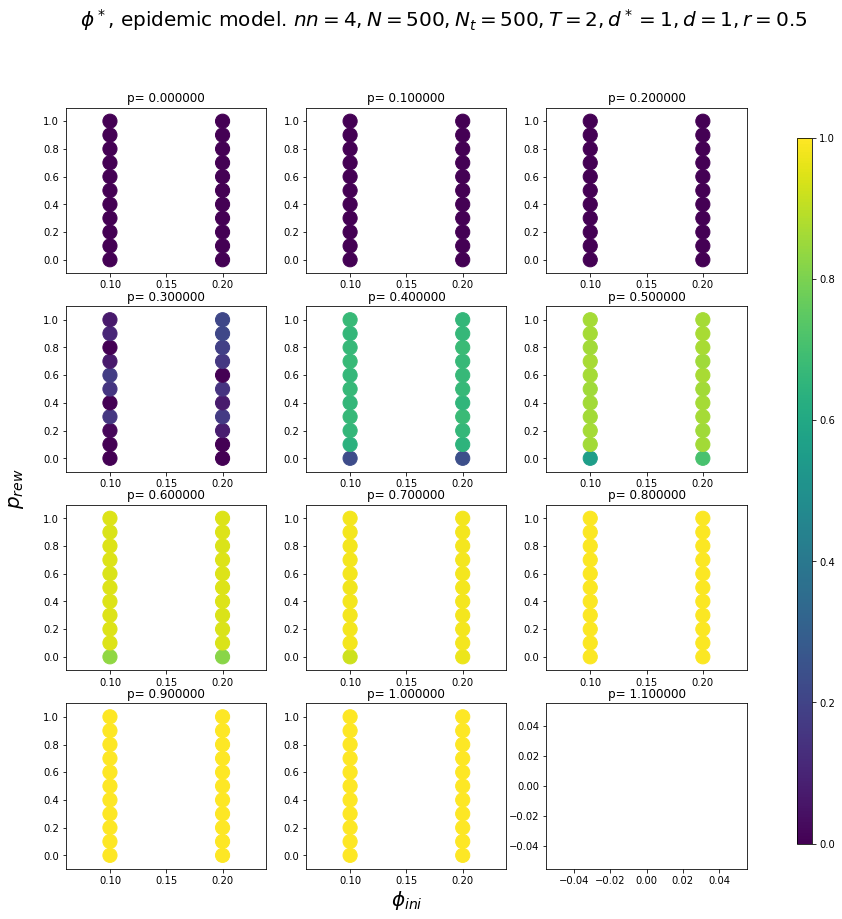

In [64]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("epid_phi_star_data_ws_pawel.txt")[:,3]

number = 22
counter = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(counter)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = number*counter
        im = col.scatter(np.loadtxt("epid_phi_star_data_ws_pawel.txt")[j:number*(counter+1),1],np.loadtxt("epid_phi_star_data_ws_pawel.txt")[j:number*(counter+1),2], c=np.loadtxt("epid_phi_star_data_ws_pawel.txt")[j:number*(counter+1),3],s=200,vmin=0, vmax=1)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, epidemic model. $nn=4,N=500,N_t=500,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("epid_params_pawel.svg", format="svg")
plt.show()

In [65]:
a = np.loadtxt("epid_time_series_ws_pawel.txt")[0,:]

df = pd.DataFrame(a,index=range(0,500))
# a = np.loadtxt("critic_time_series_ws_winnie.txt")[120,:]
# df[2] = pd.DataFrame(a,index=range(0,1000))

for i in range(1,242) :
    print(i)
    a = np.loadtxt("epid_time_series_ws_pawel.txt")[i,:]
    df[i] = pd.DataFrame(a,index=range(0,500))
df


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241


,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,...,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200
1,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,...,0.226,0.262,0.308,0.276,0.296,0.300,0.314,0.312,0.306,0.314
2,0.052,0.046,0.060,0.044,0.040,0.058,0.064,0.054,0.052,0.052,...,0.270,0.346,0.438,0.392,0.414,0.414,0.422,0.450,0.426,0.456
3,0.020,0.024,0.032,0.020,0.014,0.016,0.030,0.030,0.012,0.024,...,0.322,0.442,0.568,0.498,0.544,0.528,0.574,0.596,0.548,0.594
4,0.010,0.018,0.016,0.014,0.006,0.006,0.010,0.014,0.006,0.012,...,0.372,0.526,0.708,0.644,0.690,0.628,0.708,0.734,0.698,0.734
5,0.002,0.012,0.010,0.004,0.006,0.004,0.008,0.008,0.002,0.002,...,0.424,0.616,0.808,0.764,0.810,0.758,0.830,0.864,0.860,0.850
6,0.002,0.006,0.006,0.004,0.002,0.002,0.002,0.004,0.002,0.000,...,0.494,0.700,0.908,0.864,0.890,0.858,0.918,0.940,0.942,0.930
7,0.000,0.002,0.004,0.002,0.000,0.002,0.000,0.000,0.000,0.000,...,0.548,0.778,0.964,0.946,0.942,0.934,0.958,0.982,0.972,0.982
8,0.000,0.002,0.000,0.002,0.000,0.002,0.000,0.000,0.000,0.000,...,0.624,0.866,0.986,0.988,0.974,0.978,0.990,0.994,0.988,0.998
9,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,...,0.680,0.926,0.998,1.000,0.980,0.994,1.000,0.998,0.998,1.000


In [66]:
df.to_csv('df_epid_time_series_ws_pawel.csv')

In [67]:
df = pd.read_csv('df_epid_time_series_ws_pawel.csv')

In [ ]:
# point = 847+22+1

# x = df.iloc[:, [point]]
# # smooth = x.rolling(window=100,center=False).mean().shift(-199)
# smooth = x.rolling(window=100,center=True).mean()
# # plt.plot(smooth)
# a = np.loadtxt("critic_time_series_ws_pawel.txt")[point-1,:]
# plt.plot(a)
# plt.show()
# print(smooth.iloc[[point], [0]])
# # print(np.isnan(smooth.iloc[[0], [0]]))
# print(pd.isnull(smooth.iloc[[0], [0]]))

In [68]:
def time_reach_ss(point,lim,tol,window_size) :
    x = df.iloc[:, [point]]
    # smooth = x.rolling(window=100,center=False).mean().shift(-199)
    smooth = x.rolling(window=window_size,center=True).mean()
    count = 0
    b = np.loadtxt("epid_phi_star_data_ws_pawel.txt")[point-1,3]
    print('steady_state_phi_star=',b)
    for i in range(0,500) :
        if not(pd.isnull(smooth.iloc[[i], [0]]).bool()): 
#             print((smooth.iloc[[i], [0]]))
            j = i
            while (((smooth.iloc[[j], [0]]) < (tol+b)) & ((smooth.iloc[[j], [0]]) > (b-tol)) & (j<i+100)).bool() :
                count = count + 1
#                 print('count = ',count)
                j = j + 1
    #             if j == i + 100 : 
            if count >= lim :
                count = 0
                print('steady state reached at i = ',i)
                return i

In [69]:
#opening a file to store data
g = open("epid_ss_ws_pawel.txt","w+") 

point = 1
for p in range(0,11) :
    p = p*0.1
    for start in range(1,3) :
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            print('p=',p)
            print('start=',start)
            print('p_rew=',p_rew)
#             for point in range(484+77,484+77+11) :
            print('point=',point)
            tol = 0.005
            lim = 200
            window_size = 50
            i = time_reach_ss(point,lim,tol,window_size)
            if i is not None :
                g.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,i))
                g.flush()
                point = point + 1
            else :
#                 g.write("%f\t%f\t%f\t\n" % (p,start,p_rew))
                point = point + 1

p= 0.0
start= 0.1
p_rew= 0.0
point= 1
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.1
point= 2
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.2
point= 3
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.30000000000000004
point= 4
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.4
point= 5
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.5
point= 6
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.6000000000000001
point= 7
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.7000000000000001
point= 8
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.8
point= 9
steady_state_phi_star= 0.0
steady state reached at i =  27
p= 0.0
start= 0.1
p_rew= 0.9
point= 10
steady_state_phi_star= 0.0
steady state re

p= 0.30000000000000004
start= 0.2
p_rew= 0.4
point= 82
steady_state_phi_star= 0.07405
p= 0.30000000000000004
start= 0.2
p_rew= 0.5
point= 83
steady_state_phi_star= 0.14909
steady state reached at i =  409
p= 0.30000000000000004
start= 0.2
p_rew= 0.6000000000000001
point= 84
steady_state_phi_star= 0.00174
steady state reached at i =  327
p= 0.30000000000000004
start= 0.2
p_rew= 0.7000000000000001
point= 85
steady_state_phi_star= 0.16282
steady state reached at i =  408
p= 0.30000000000000004
start= 0.2
p_rew= 0.8
point= 86
steady_state_phi_star= 0.19083
steady state reached at i =  417
p= 0.30000000000000004
start= 0.2
p_rew= 0.9
point= 87
steady_state_phi_star= 0.21433
steady state reached at i =  63
p= 0.30000000000000004
start= 0.2
p_rew= 1.0
point= 88
steady_state_phi_star= 0.21147
steady state reached at i =  332
p= 0.4
start= 0.1
p_rew= 0.0
point= 89
steady_state_phi_star= 0.22974
p= 0.4
start= 0.1
p_rew= 0.1
point= 90
steady_state_phi_star= 0.63955
steady state reached at i =  13

steady state reached at i =  59
p= 0.7000000000000001
start= 0.1
p_rew= 0.2
point= 157
steady_state_phi_star= 0.98217
steady state reached at i =  42
p= 0.7000000000000001
start= 0.1
p_rew= 0.30000000000000004
point= 158
steady_state_phi_star= 0.98088
steady state reached at i =  38
p= 0.7000000000000001
start= 0.1
p_rew= 0.4
point= 159
steady_state_phi_star= 0.98065
steady state reached at i =  39
p= 0.7000000000000001
start= 0.1
p_rew= 0.5
point= 160
steady_state_phi_star= 0.98002
steady state reached at i =  39
p= 0.7000000000000001
start= 0.1
p_rew= 0.6000000000000001
point= 161
steady_state_phi_star= 0.9816
steady state reached at i =  38
p= 0.7000000000000001
start= 0.1
p_rew= 0.7000000000000001
point= 162
steady_state_phi_star= 0.98305
steady state reached at i =  38
p= 0.7000000000000001
start= 0.1
p_rew= 0.8
point= 163
steady_state_phi_star= 0.98259
steady state reached at i =  39
p= 0.7000000000000001
start= 0.1
p_rew= 0.9
point= 164
steady_state_phi_star= 0.98171
steady stat

p= 1.0
start= 0.2
p_rew= 0.0
point= 232
steady_state_phi_star= 1.0
steady state reached at i =  250
p= 1.0
start= 0.2
p_rew= 0.1
point= 233
steady_state_phi_star= 1.0
steady state reached at i =  40
p= 1.0
start= 0.2
p_rew= 0.2
point= 234
steady_state_phi_star= 1.0
steady state reached at i =  35
p= 1.0
start= 0.2
p_rew= 0.30000000000000004
point= 235
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.2
p_rew= 0.4
point= 236
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.2
p_rew= 0.5
point= 237
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.2
p_rew= 0.6000000000000001
point= 238
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.2
p_rew= 0.7000000000000001
point= 239
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.2
p_rew= 0.8
point= 240
steady_state_phi_star= 1.0
steady state reached at i =  31
p= 1.0
start= 0.2
p_rew= 0.9
point= 241
steady_state_phi_star=

226
AxesSubplot(0.125,0.71587;0.227941x0.16413)
0 0
0.0
AxesSubplot(0.398529,0.71587;0.227941x0.16413)
22 0.1
0.1
AxesSubplot(0.672059,0.71587;0.227941x0.16413)
44 0.2
0.2
AxesSubplot(0.125,0.518913;0.227941x0.16413)
66 0.3
0.3
AxesSubplot(0.398529,0.518913;0.227941x0.16413)
80 0.4
0.4
AxesSubplot(0.672059,0.518913;0.227941x0.16413)
100 0.5
0.5
AxesSubplot(0.125,0.321957;0.227941x0.16413)
120 0.6
0.6
AxesSubplot(0.398529,0.321957;0.227941x0.16413)
140 0.7
0.7
AxesSubplot(0.672059,0.321957;0.227941x0.16413)
160 0.8
0.8
AxesSubplot(0.125,0.125;0.227941x0.16413)
182 0.9
0.9
AxesSubplot(0.398529,0.125;0.227941x0.16413)
204 1.0
1.0
AxesSubplot(0.672059,0.125;0.227941x0.16413)
225 1.1
1.0


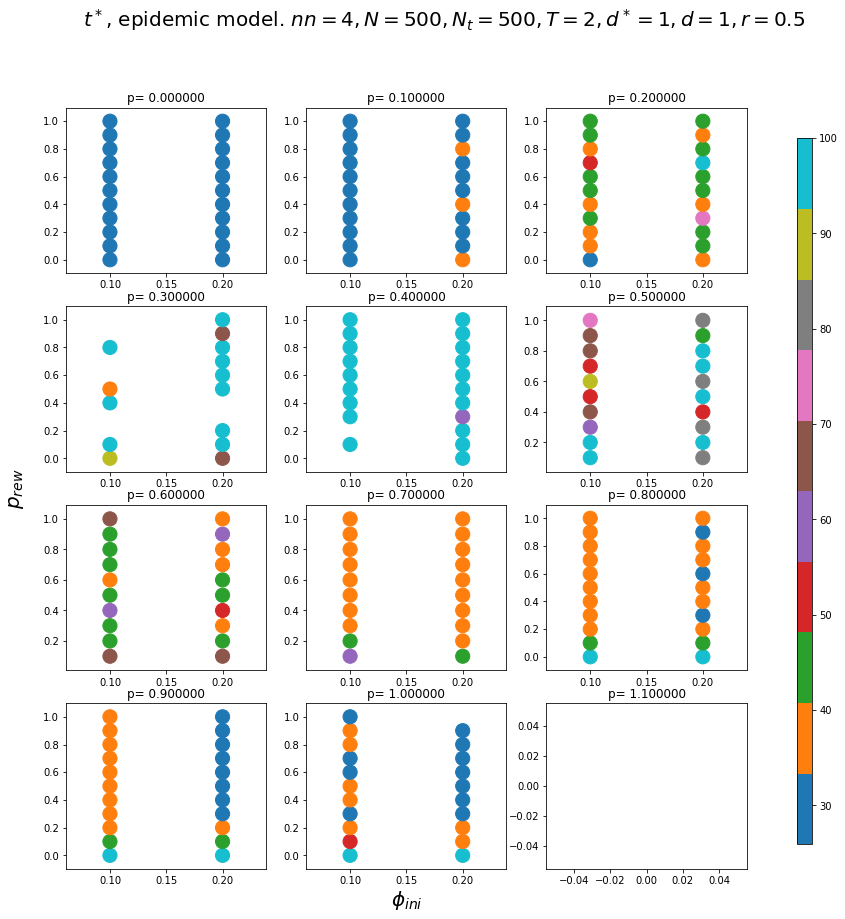

In [70]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("epid_ss_ws_pawel.txt")[:,3]
print(len(d))
count = 0
plot_count = 1
j = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
#         count = count + plot_count-1
        plot_count = 0
        print(count,round(l,2))
        print(np.loadtxt("epid_ss_ws_pawel.txt")[count,0])
        while (count < len(d)-1) and np.loadtxt("epid_ss_ws_pawel.txt")[count,0] == round(l,2)  :
            plot_count = plot_count + 1
            count = count + 1
#             print(count)
        end =  count
#         count = plot_count-1
        im = col.scatter(np.loadtxt("epid_ss_ws_pawel.txt")[j:end,1],np.loadtxt("epid_ss_ws_pawel.txt")[j:end,2], c=np.loadtxt("epid_ss_ws_pawel.txt")[j:end,3],s=200,vmin=26,vmax=100,cmap='tab10')
        j = end
        l = l + 0.1
        k = k + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$t^*$, epidemic model. $nn=4,N=500,N_t=500,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("epid_steady_state_pawel.svg", format="svg")